# Leios simulation analysis at tag `leios-2025w29`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: Linear Leios

In [2]:
label <- "Rust simulator, mini-mainnet, 100 tx/s, 1400 B/tx"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(lifecycle, sampleSize, file="results/lifecycle.R")
}
lifecycle[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator                           Variant              Stage length   
 Rust:1077698   linear                   :538892   5 slot/stage :538848  
                linear-with-tx-references:538806   8 slot/stage :538850  
                                                   15 slot/stage:     0  
                                                                         
                                                                         
                                                                         
                                                                         
     Max EB size     Kind                   Item            Size [B]       
 5.0 MB/EB :359252   EB:    691   20-node-220 :     24   Min.   :     240  
 20.0 MB/EB:359224   RB:    691   26-node-95  :     24   1st Qu.:    1400  
 10.0 MB/EB:359222   TX:1076316   54-node-525 :     24   Median :    1400  
 50.0 MB/EB:     0                95-node-178 :     18   Mean   :    3759  
 2.0 MB/EB :     0          

#### Range of transaction injection

In [4]:
txFirst <- 0
txLast <- 900
txWindow <- txLast - txFirst
simFinish <- 1200

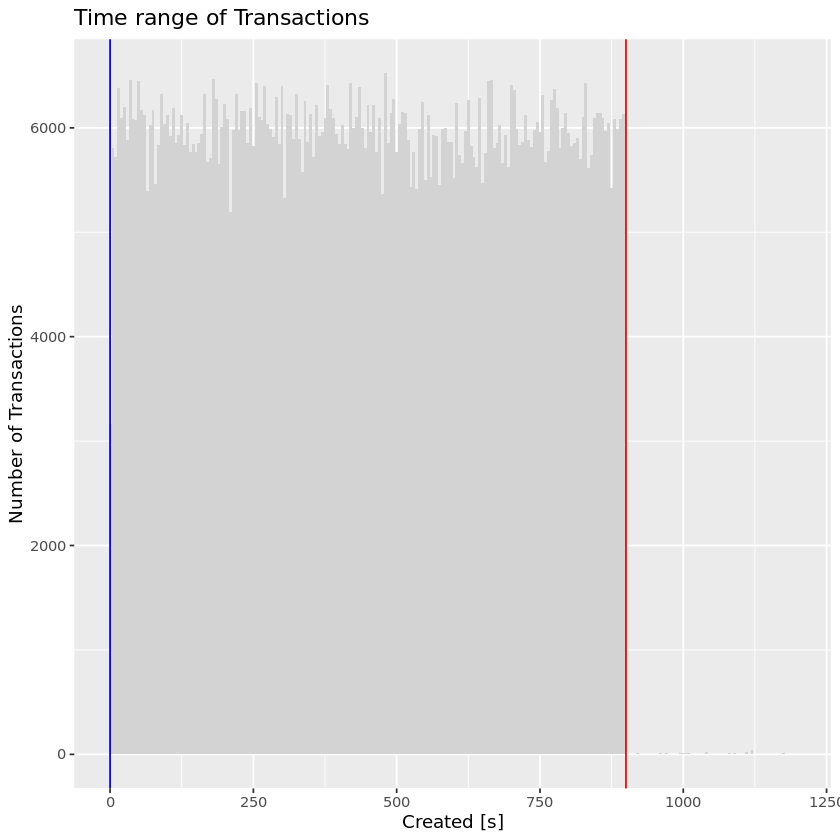

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [Mb/s]`=8*sum(`Size [B]`)/1e6/txWindow,
        `Time to full EB [s]`=1/(sum(`Size [B]`)/(1e6*as.numeric(substring(`Max EB size`, 1, 4)))/txWindow),
        `Transaction size [B/tx]`=sum(`Size [B]`)/.N
    ),
    .(`Variant`, `Stage length`, `Max EB size`)
][order(`Variant`, `Stage length`, - `Max EB size`)]

Variant,Stage length,Max EB size,Demand [tx/s],Demand [MB/s],Demand [Mb/s],Time to full EB [s],Transaction size [B/tx]
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
linear,5 slot/stage,5.0 MB/EB,99.65889,0.1395224,1.11618,35.83653,1400
linear,5 slot/stage,10.0 MB/EB,99.65889,0.1395224,1.11618,71.67306,1400
linear,5 slot/stage,20.0 MB/EB,99.65889,0.1395224,1.11618,143.34611,1400
linear,8 slot/stage,5.0 MB/EB,99.65889,0.1395224,1.11618,35.83653,1400
linear,8 slot/stage,10.0 MB/EB,99.65889,0.1395224,1.11618,71.67306,1400
linear,8 slot/stage,20.0 MB/EB,99.65889,0.1395224,1.11618,143.34611,1400
linear-with-tx-references,5 slot/stage,5.0 MB/EB,99.65889,0.1395224,1.11618,35.83653,1400
linear-with-tx-references,5 slot/stage,10.0 MB/EB,99.65889,0.1395224,1.11618,71.67306,1400
linear-with-tx-references,5 slot/stage,20.0 MB/EB,99.65889,0.1395224,1.11618,143.34611,1400


#### Size of persisted data

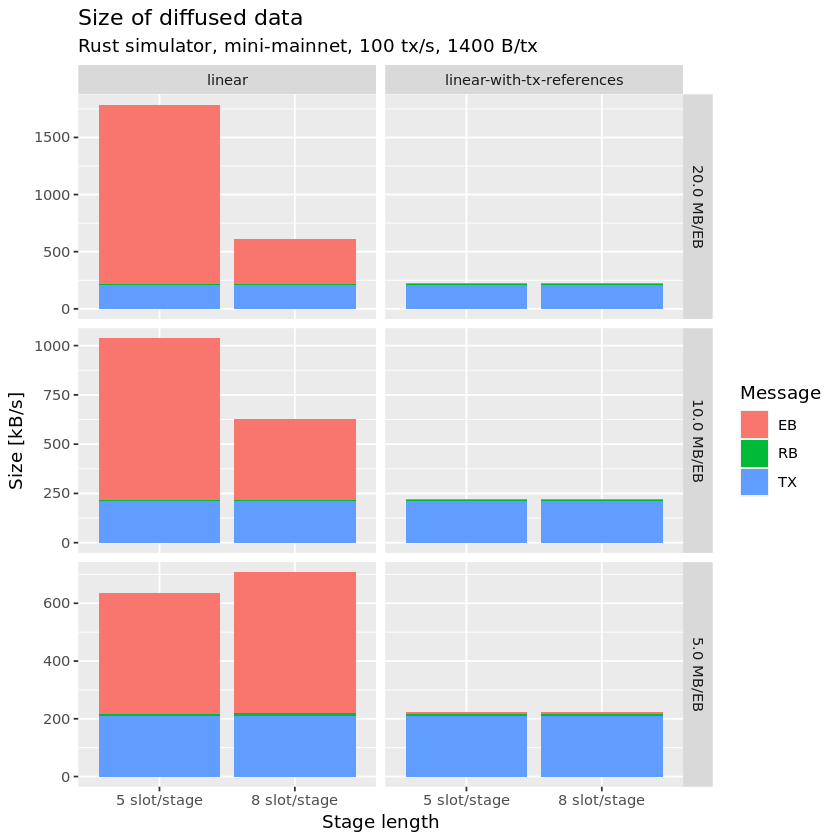

In [7]:
ggplot(
    lifecycle[,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        .(`Variant`, `Message`=`Kind`, `Stage length`, `Max EB size`)
    ],
    aes(x=`Stage length`, y=`Size [kB/s]`, fill=`Message`)
) + geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Variant`, scales="free_y") +
    ggtitle("Size of diffused data", subtitle=label)

In [8]:
ggsave("plots/sizes.png", units="in", dpi=150, width=8, height=4)

#### Spatial efficiency

In [10]:
lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`, `Stage length`, `Max EB size`)
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric((`Variant` == "linear-with-tx-references" & `Kind` == "TX" | `Kind` == "EB" | `Kind` == "RB") * `Size [B]`))), 
            .(`Variant`, `Stage length`, `Max EB size`)
        ],
        on=c("Variant", "Stage length", "Max EB size")
    ][, .(`Variant`, `Stage length`, `Max EB size`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)][order(`Variant`, `Stage length`, -`Max EB size`)]

Variant,Stage length,Max EB size,Space efficiency [%]
<fct>,<fct>,<fct>,<dbl>
linear,5 slot/stage,5.0 MB/EB,47.263229
linear,5 slot/stage,10.0 MB/EB,5.412314
linear,5 slot/stage,20.0 MB/EB,2.808371
linear,8 slot/stage,5.0 MB/EB,42.014002
linear,8 slot/stage,10.0 MB/EB,49.915335
linear,8 slot/stage,20.0 MB/EB,51.593285
linear-with-tx-references,5 slot/stage,5.0 MB/EB,93.970815
linear-with-tx-references,5 slot/stage,10.0 MB/EB,93.988888
linear-with-tx-references,5 slot/stage,20.0 MB/EB,93.488622


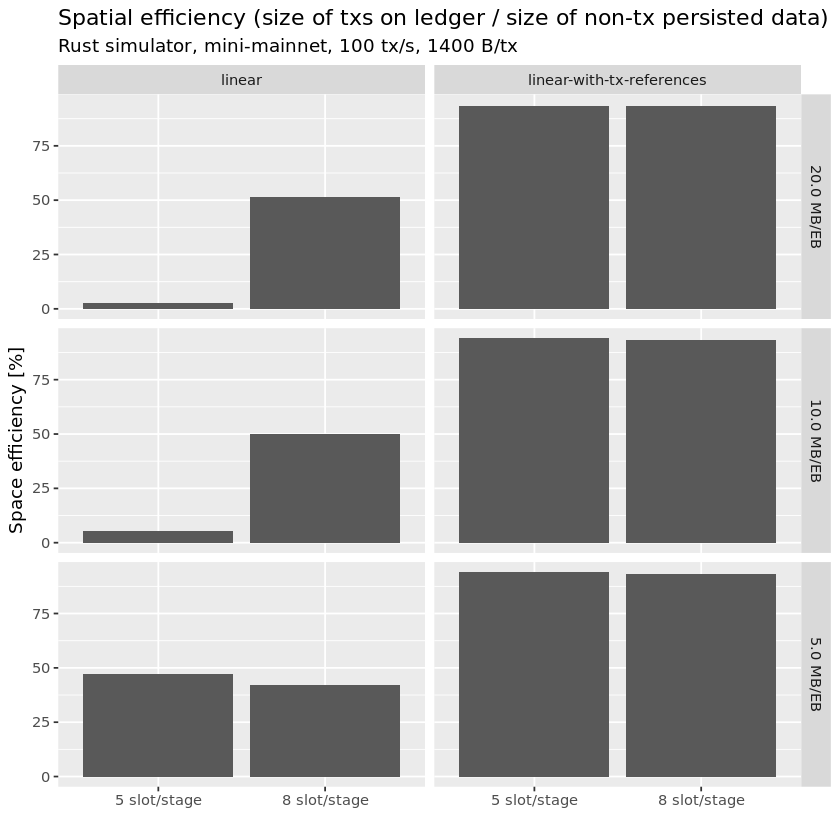

In [11]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`, `Stage length`, `Max EB size`)
    ][
        lifecycle[
            `Kind` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric((`Variant` == "linear-with-tx-references" & `Kind` == "TX" | `Kind` == "EB" | `Kind` == "RB") * `Size [B]`))), 
            .(`Variant`, `Stage length`, `Max EB size`)
        ],
        on=c("Variant", "Stage length", "Max EB size")
    ][, .(`Variant`, `Stage length`, `Max EB size`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Stage length`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Variant`) +
    xlab("") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [12]:
ggsave("plots/spatial-efficiency.png", units="in", dpi=150, width=8, height=4)

#### Time to reach the EB

In [14]:
lifecycle[
        `Kind` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=mean(`To EB [s]`-`Created [s]`)), 
        .(`Variant`, `Stage length`, `Max EB size`)
    ][order(`Variant`, `Stage length`, -`Max EB size`)]

Variant,Stage length,Max EB size,Time to reach EB [s]
<fct>,<fct>,<fct>,<dbl>
linear,5 slot/stage,5.0 MB/EB,43.75952
linear,5 slot/stage,10.0 MB/EB,133.37920
linear,5 slot/stage,20.0 MB/EB,110.31655
linear,8 slot/stage,5.0 MB/EB,112.19665
linear,8 slot/stage,10.0 MB/EB,19.18949
linear,8 slot/stage,20.0 MB/EB,17.71555
linear-with-tx-references,5 slot/stage,5.0 MB/EB,50.34918
linear-with-tx-references,5 slot/stage,10.0 MB/EB,21.69799
linear-with-tx-references,5 slot/stage,20.0 MB/EB,21.50913


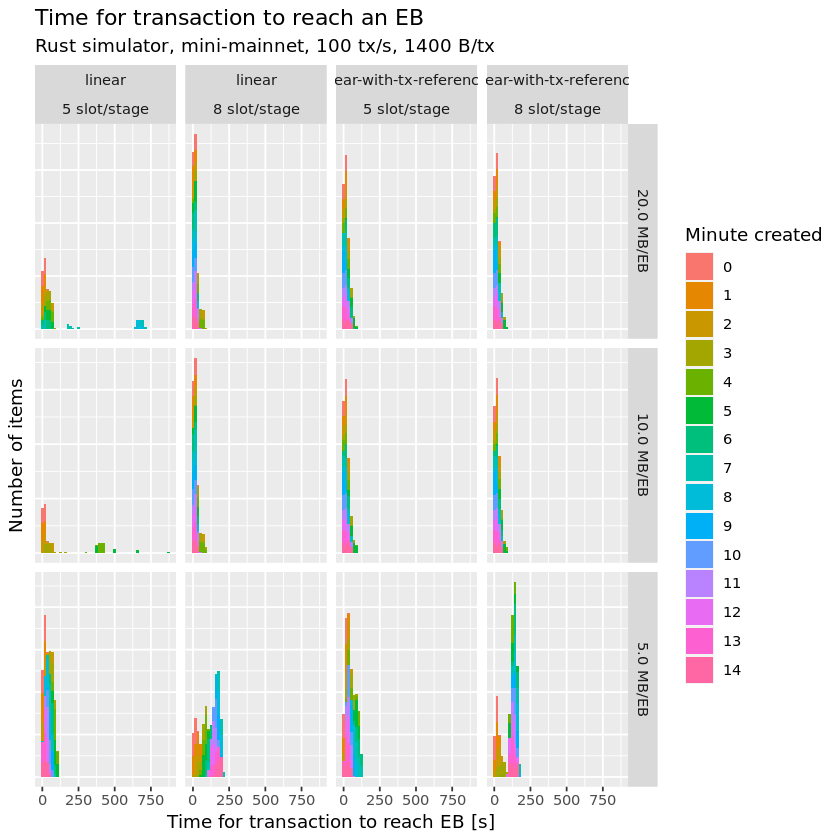

In [15]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` < txLast, 
        .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
        .(`Variant`, `Stage length`, `Max EB size`, `Minute created`=factor(floor(`Created [s]`/60)))
    ],
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
#   scale_x_log10() +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales="free_y") +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach an EB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [16]:
ggsave("plots/reach-eb-tx.png", units="in", dpi=150, width=8, height=4)

#### Time to reach the ledger

In [17]:
lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`To RB [s]`-`Created [s]`)), 
        .(`Variant`, `Stage length`, `Max EB size`)
    ]

Variant,Stage length,Max EB size,Time to reach ledger [s]
<fct>,<fct>,<fct>,<dbl>
linear,5 slot/stage,5.0 MB/EB,76.27580
linear,5 slot/stage,10.0 MB/EB,47.19447
linear,5 slot/stage,20.0 MB/EB,47.18600
linear,8 slot/stage,5.0 MB/EB,159.23294
linear,8 slot/stage,10.0 MB/EB,63.71906
linear,8 slot/stage,20.0 MB/EB,62.31809
linear-with-tx-references,5 slot/stage,10.0 MB/EB,61.40164
linear-with-tx-references,5 slot/stage,20.0 MB/EB,62.86204
linear-with-tx-references,5 slot/stage,5.0 MB/EB,89.45720


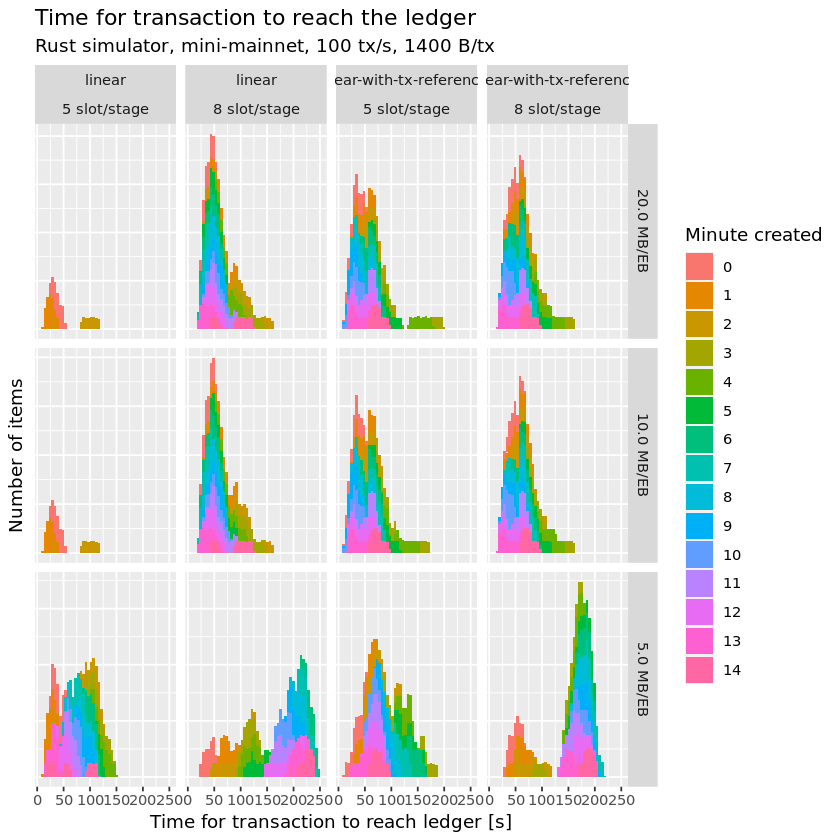

In [18]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` < txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Variant`, `Kind`, `Stage length`, `Max EB size`, `Minute created`=factor(floor(`Created [s]`/60)))
    ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
#   scale_x_log10() +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales="free_y") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [19]:
ggsave("plots/reach-rb-tx.png", units="in", dpi=150, width=8, height=4)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

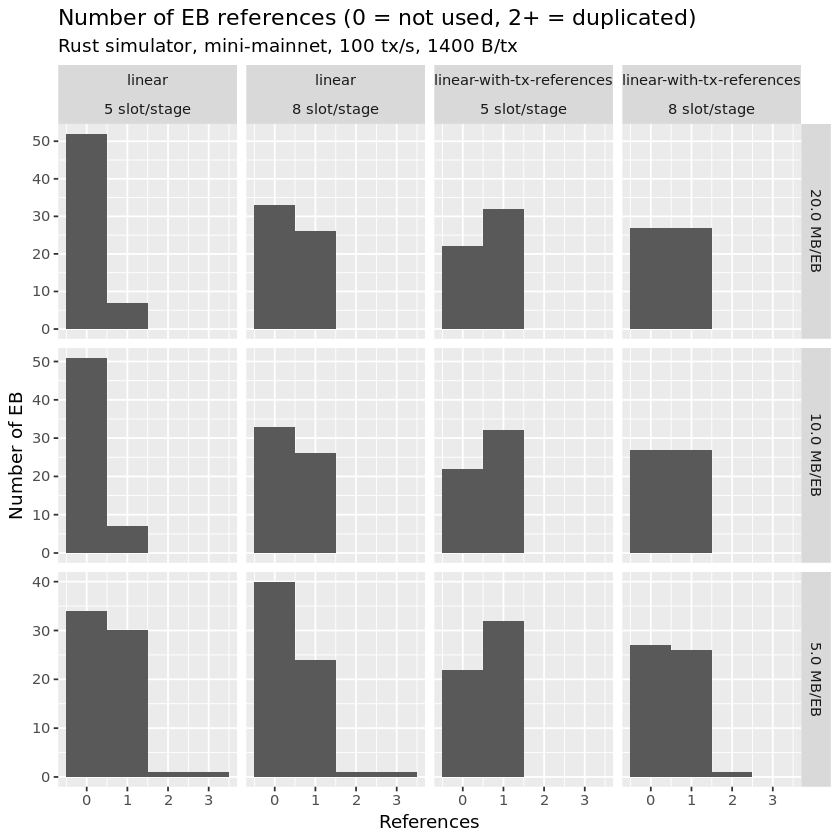

In [20]:
ggplot(
    lifecycle[
        `Kind` == "EB",
        .(`References`),
        .(`Variant`, `Stage length`, `Max EB size`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales="free_y") +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)", label)

In [21]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=8, height=4)

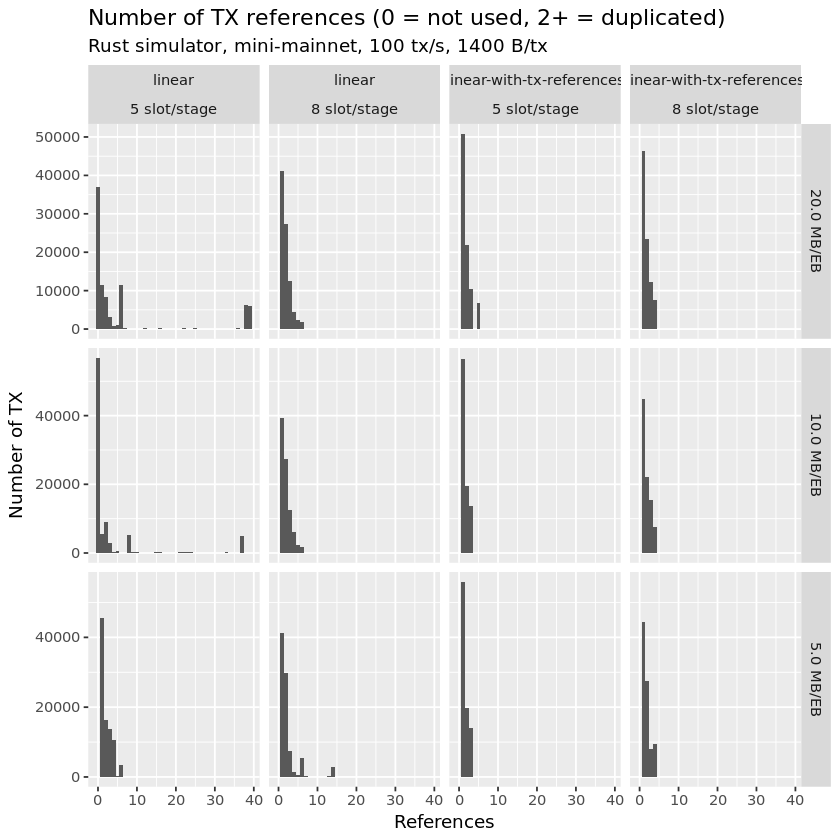

In [22]:
ggplot(
    lifecycle[
        `Kind` == "TX",
        .(`References`),
        .(`Variant`, `Stage length`, `Max EB size`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales="free_y") +
    ylab("Number of TX") +
    ggtitle("Number of TX references (0 = not used, 2+ = duplicated)", label)

In [23]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=8, height=4)

#### Temporal efficiency

In [24]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [25]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Variant`, `Stage length`, `Max EB size`
    )
][order(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [26]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`)]

#### Transactions reaching the ledger

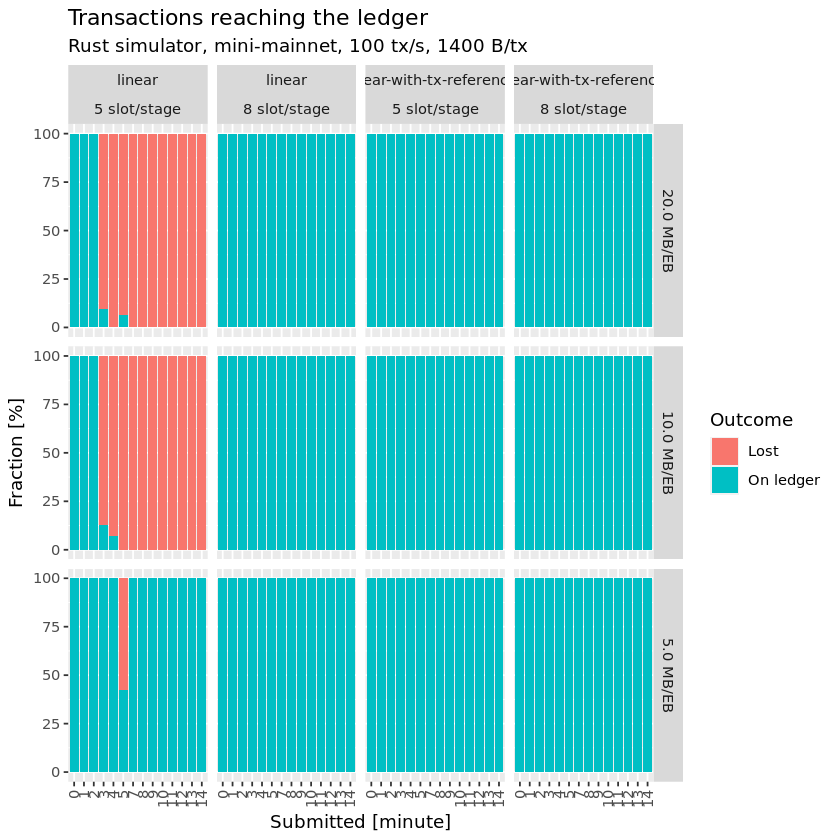

In [27]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`)],
        id.vars=c("Variant", "Stage length", "Max EB size", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[`Submitted [minute]` != 6, .(
        `Variant`,
        `Stage length`, 
        `Max EB size`,
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [28]:
ggsave("plots/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=4)

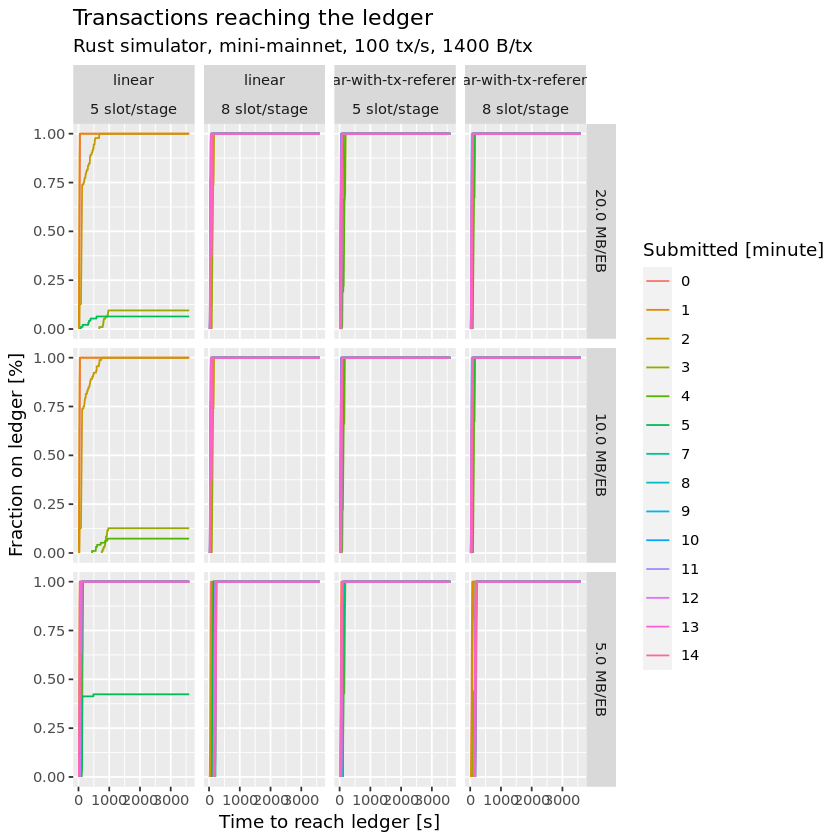

In [29]:
ggplot(
    rbind(
        totals[
            outcomes[
                !is.na(`Time to reach ledger [s]`), 
                .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), 
                .(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`)
            ],
            on=c("Variant", "Stage length", "Max EB size", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 6],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`) +
    ggtitle("Transactions reaching the ledger", label)

In [30]:
ggsave("plots/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=4)

#### Release memory

In [31]:
rm(lifecycle, outcomes, totals)

In [32]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,973729,52.1,1685067,90,1685067,90.0
Vcells,5268196,40.2,53214676,406,66495287,507.4


### Resource usage

In [33]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(resources, file="results/resources.Rdata")
}
resources[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
resources %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator                        Variant            Stage length 
 Rust:9000   linear                   :4500   5 slot/stage :4500  
             linear-with-tx-references:4500   8 slot/stage :4500  
                                              15 slot/stage:   0  
                                                                  
                                                                  
                                                                  
                                                                  
     Max EB size         Node        Egress [B]           Disk [B]       
 20.0 MB/EB:3000   node-0  :  12   Min.   :     1260   Min.   :       0  
 10.0 MB/EB:3000   node-1  :  12   1st Qu.:  9268214   1st Qu.:       0  
 5.0 MB/EB :3000   node-10 :  12   Median : 88478100   Median :       0  
 50.0 MB/EB:   0   node-100:  12   Mean   :131084302   Mean   :  282737  
 2.0 MB/EB :   0   node-101:  12   3rd Qu.:176819480   3rd Qu.:       0  
 1.0 MB/EB :   0   n

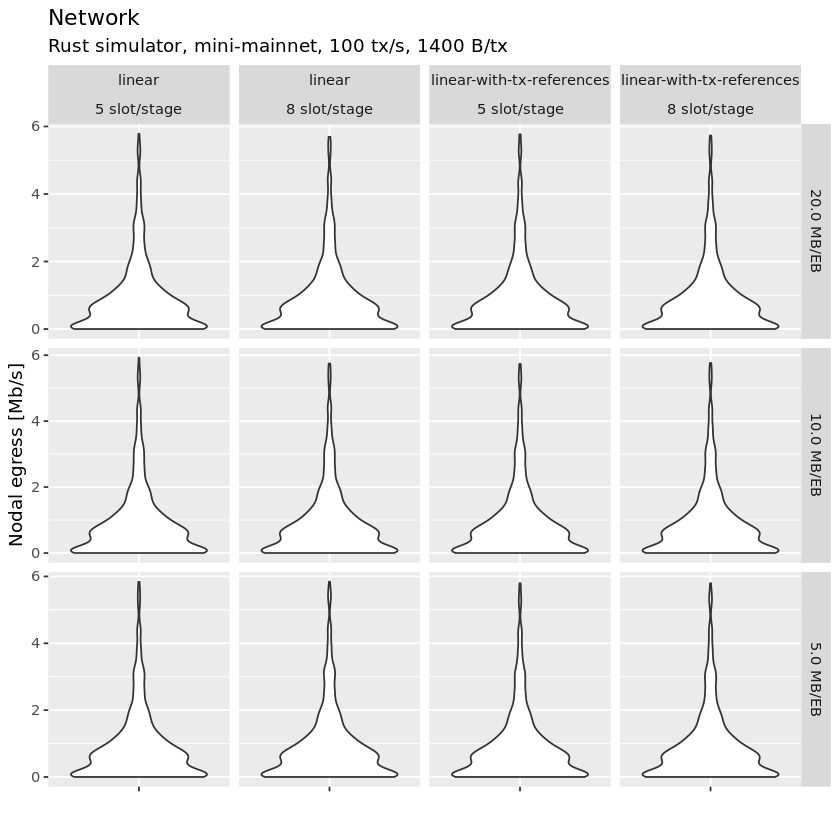

In [34]:
ggplot(
    resources[, .(`Variant`, `Stage length`, `Max EB size`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales="free_y") +
    xlab("") +
    ggtitle("Network", label)

In [35]:
ggsave("plots/network.png", units="in", dpi=150, width=8, height=4)

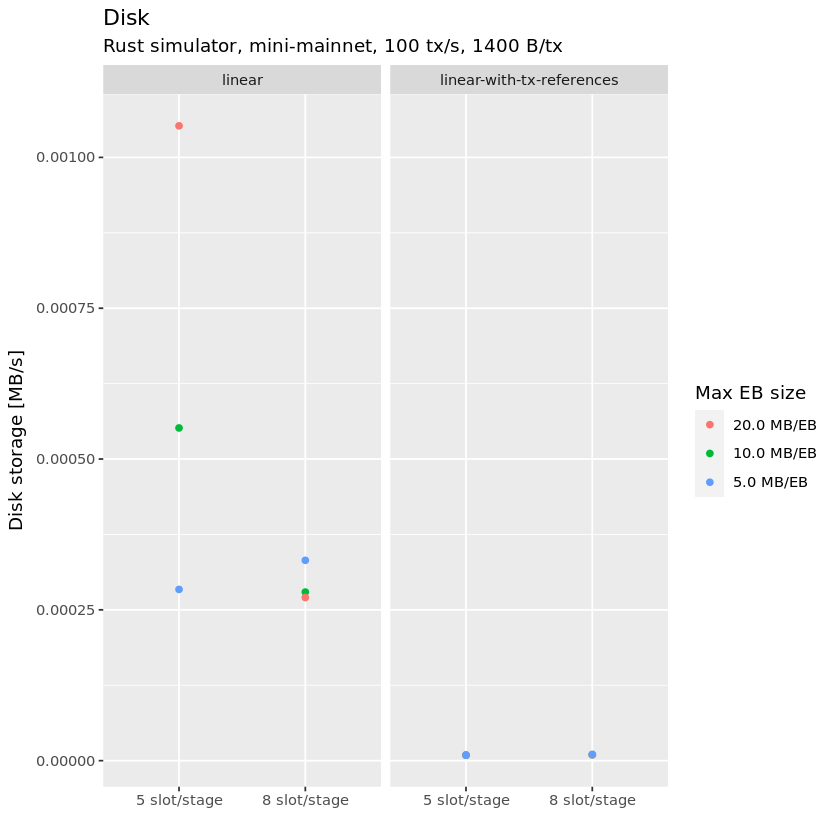

In [36]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Variant`, `Stage length`, `Max EB size`)],
    aes(x=`Stage length`, color=`Max EB size`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    xlab("") +
    facet_grid(. ~ `Variant`) +
    ggtitle("Disk", label)

In [37]:
ggsave("plots/disk.png", units="in", dpi=150, width=8, height=4)

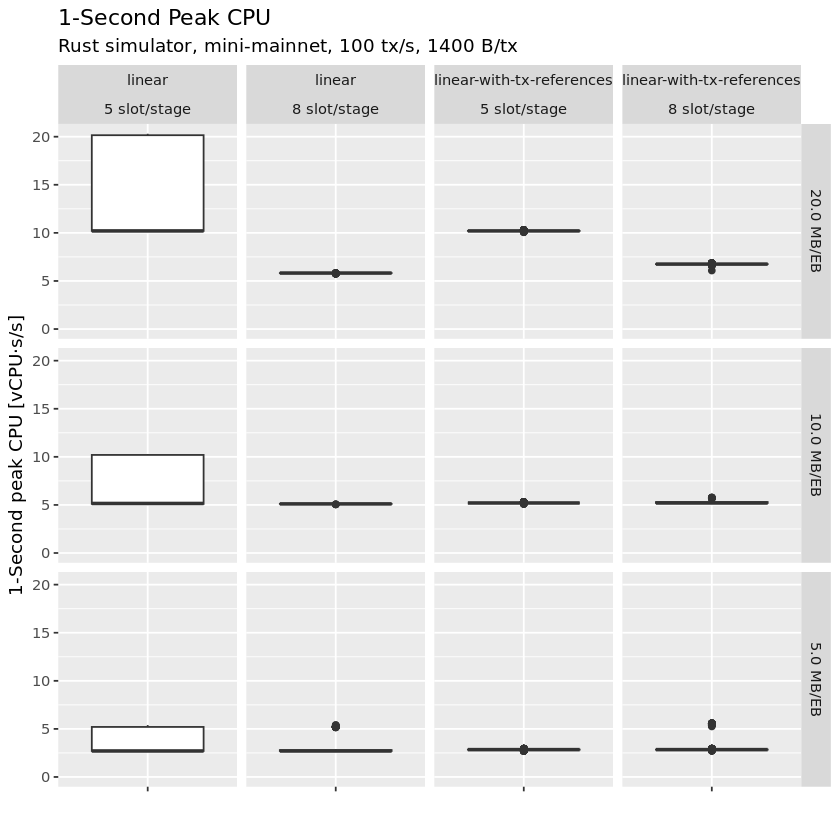

In [38]:
ggplot(
    resources[, .(`Node`, `Variant`, `Stage length`, `Max EB size`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [39]:
ggsave("plots/cpu-peak.png", units="in", dpi=150, width=8, height=4)

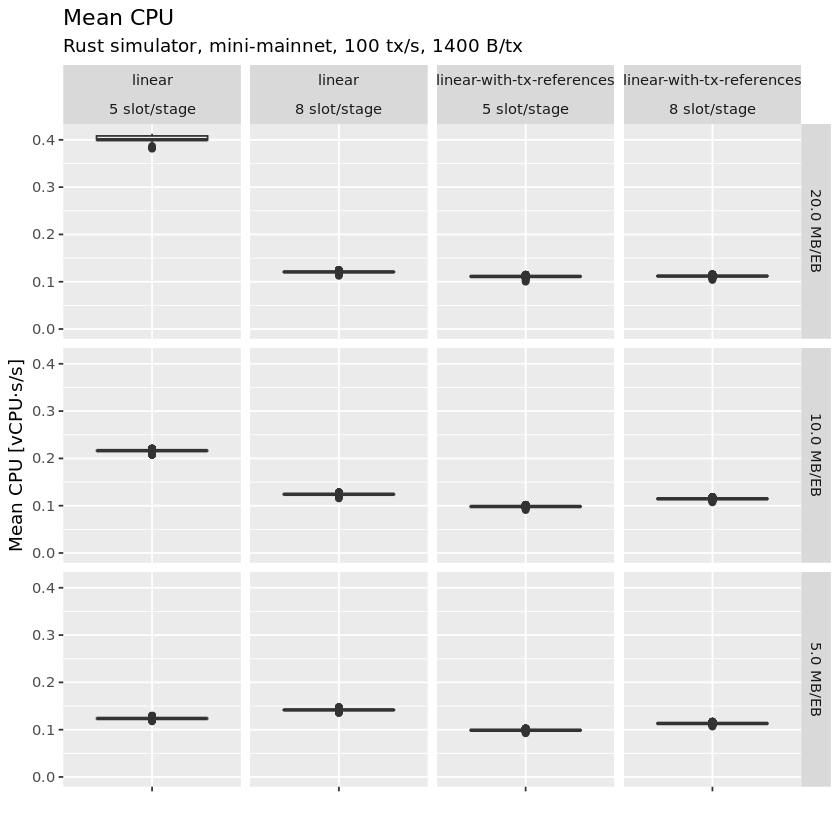

In [40]:
ggplot(
    resources[, .(`Variant`, `Stage length`, `Max EB size`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [41]:
ggsave("plots/cpu-mean.png", units="in", dpi=150, width=8, height=4)

#### Release memory

In [42]:
rm(resources)

In [43]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1004151,53.7,1685067,90.0,1685067,90.0
Vcells,1860124,14.2,42571741,324.8,66495287,507.4


### Receipt of messages

#### Read results

In [44]:
if (file.exists("results/receipts.Rdata")) {
    load("results/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(receipts, file="results/receipts.Rdata")
}
receipts[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
receipts %>% summary

Loaded Rdata file: sampleSize = 0.2 


 Simulator                             Variant                Stage length     
 Rust:176803178   linear                   :87084625   5 slot/stage :87276057  
                  linear-with-tx-references:89718553   8 slot/stage :89527121  
                                                       15 slot/stage:       0  
                                                                               
                                                                               
                                                                               
                                                                               
     Max EB size       Kind                     Item          
 5.0 MB/EB :59529765   EB:   102768   26-node-95  :     5541  
 10.0 MB/EB:58652657   RB:   112864   54-node-525 :     5450  
 20.0 MB/EB:58620756   TX:161292766   20-node-220 :     3601  
 50.0 MB/EB:       0   VT: 15294780   839-node-148:     3294  
 2.0 MB/EB :       0                  749-nod

In [45]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [46]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=4, dpi=150) {
    g <- ggplot(
        rs[, .(`Variant`, `Stage length`, `Max EB size`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

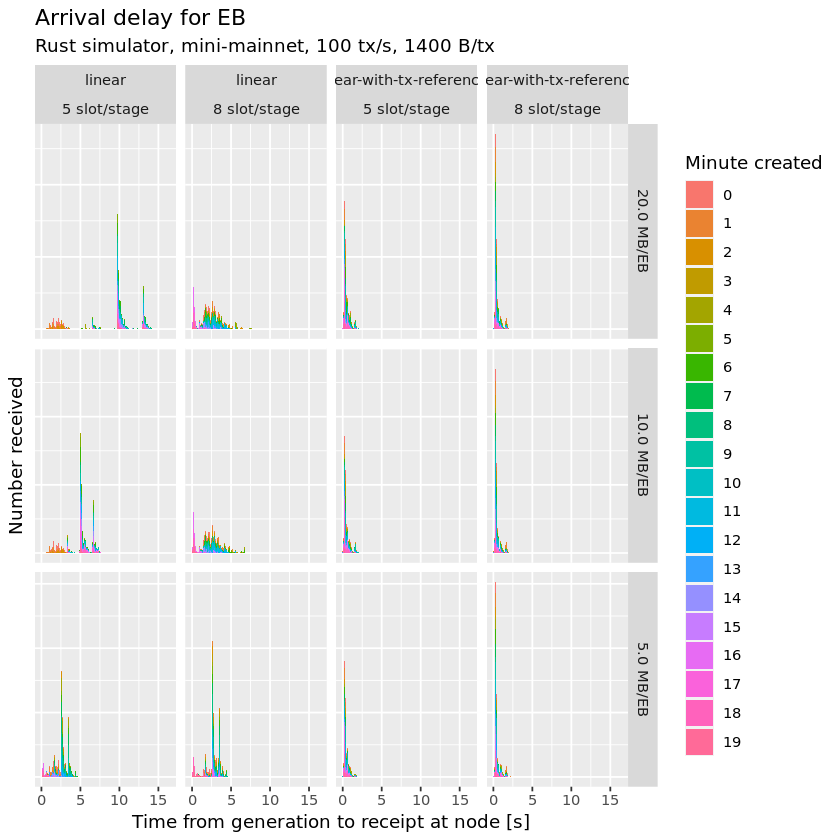

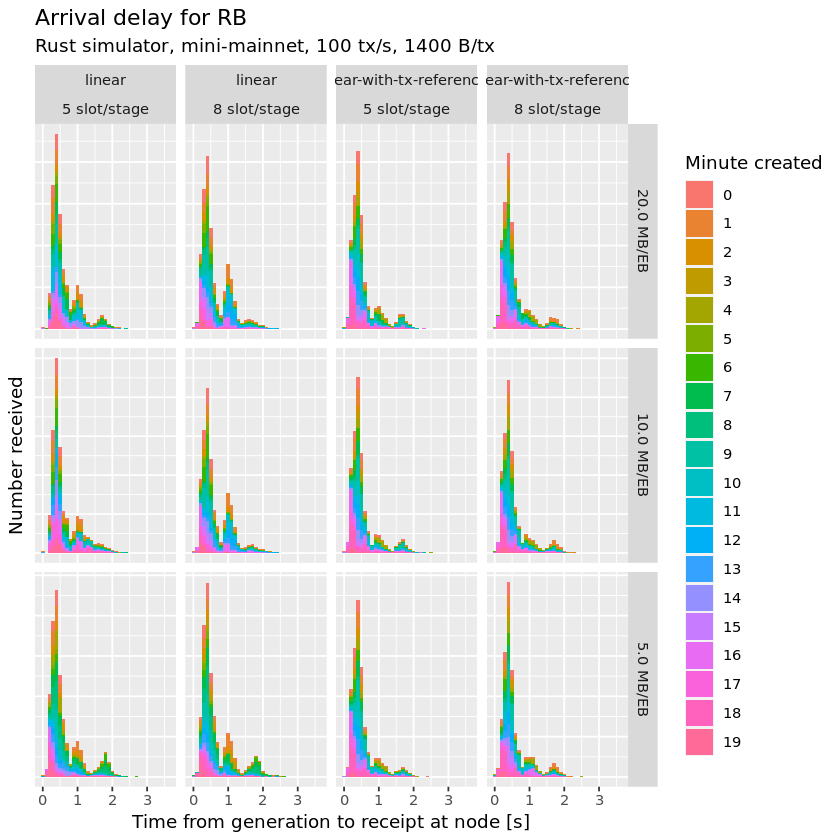

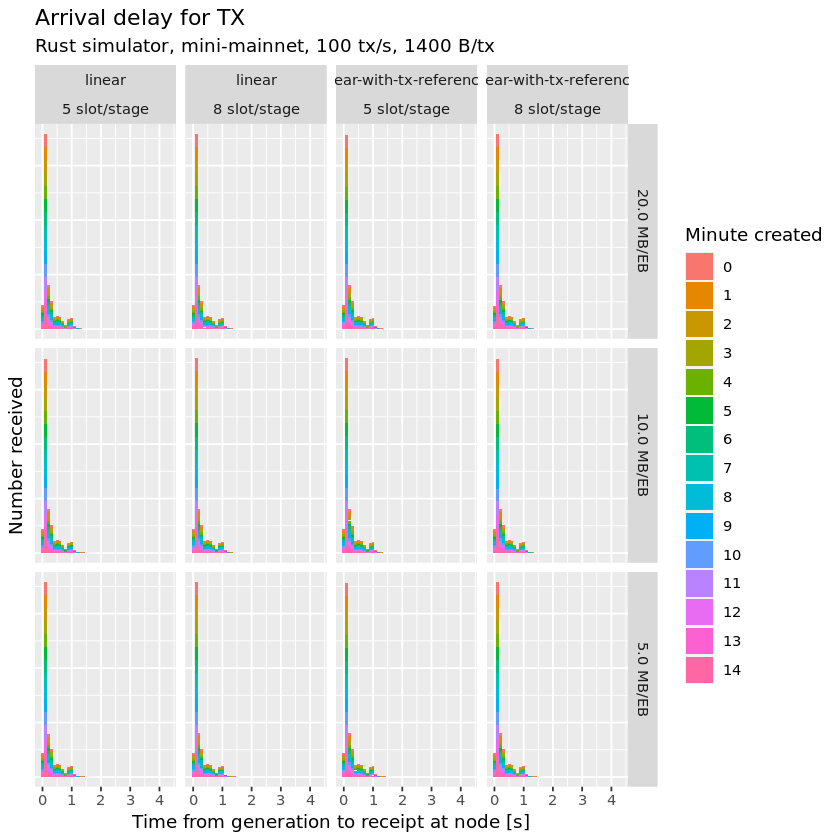

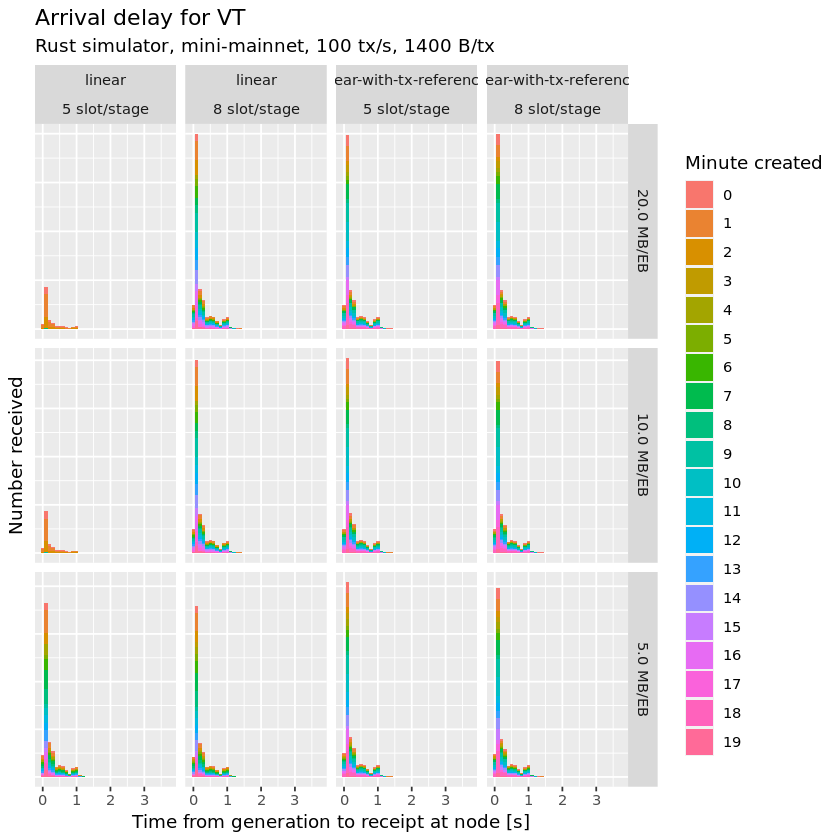

In [47]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/elapsed-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [48]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=4, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

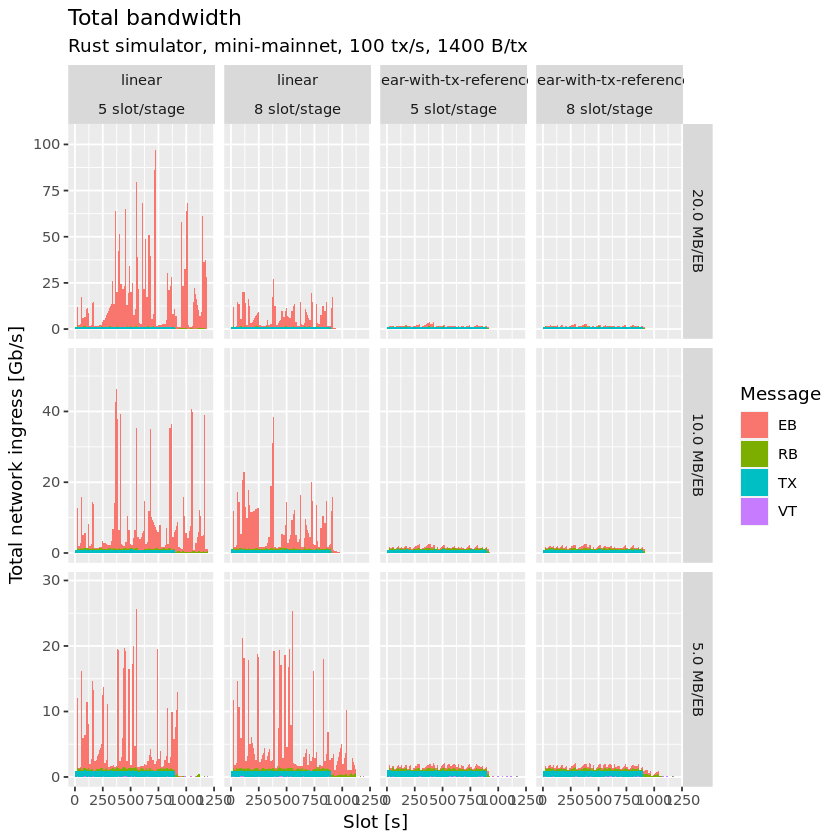

In [49]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="free_y",
    outfiles=paste0("plots/ingress-total-area.png")
)

##### Bandwidth usage per node

In [50]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [51]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=4, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

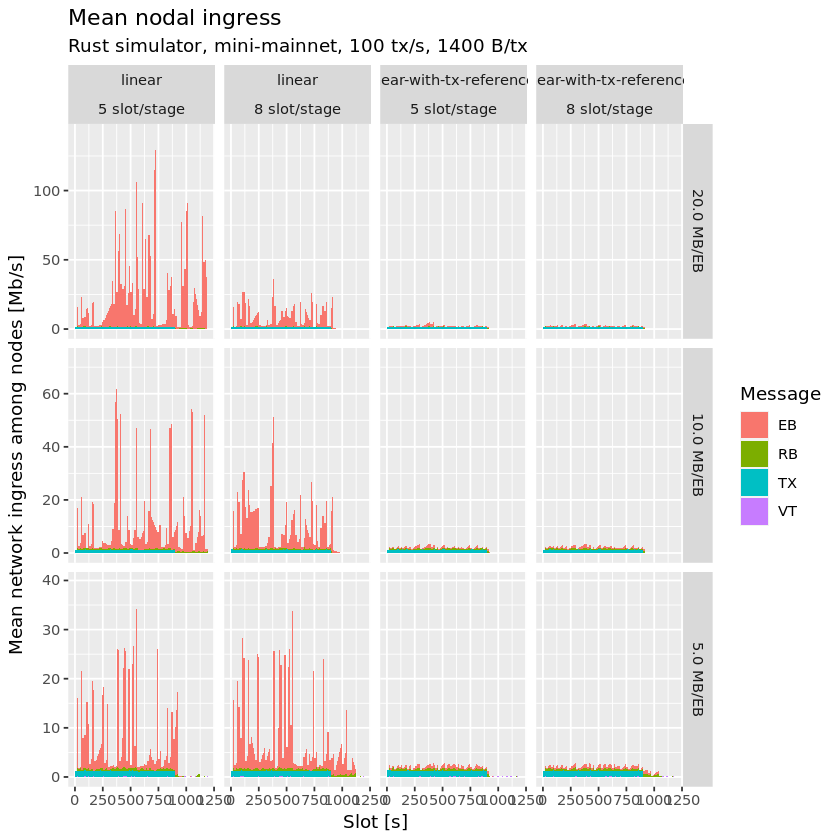

In [52]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    scales="free_y",
    outfiles=paste0("plots/ingress-average-area.png")
)

In [53]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=4, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`, `Recipient`)
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

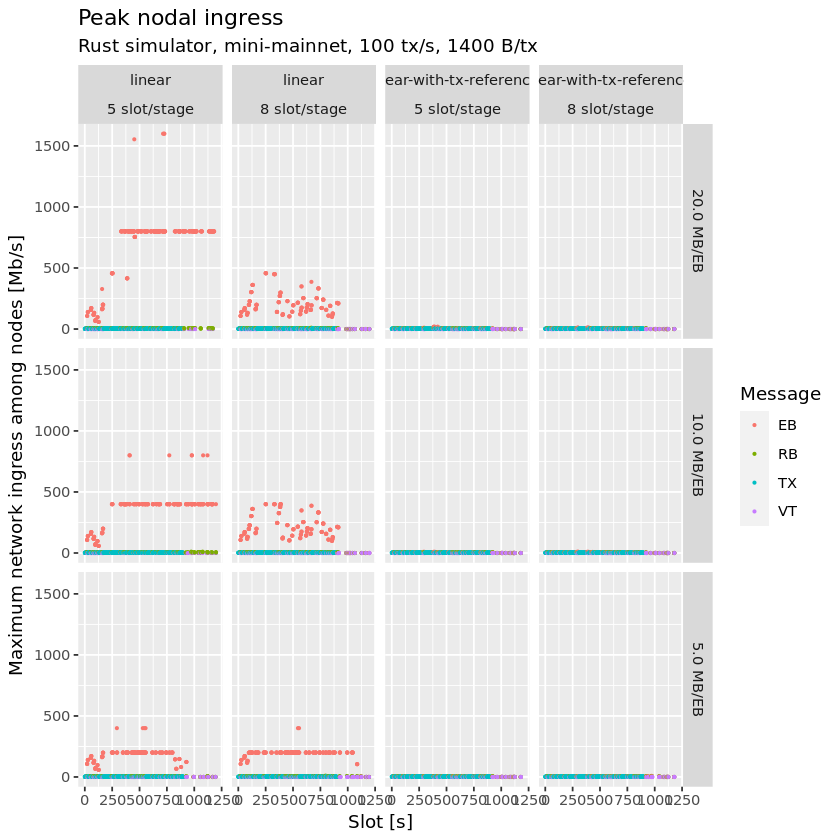

In [54]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/ingress-peak-point.png")
)

#### Release memory

In [55]:
rm(receipts)

In [56]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1134811,60.7,2538492,135.6,2538492,135.6
Vcells,1416684672,10808.5,3953648532,30164.0,6177575831,47131.2


### CPU usage

#### Read results

In [57]:
if (file.exists("results/cpus.Rdata")) {
    load(file="results/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(cpus, file="results/cpus.Rdata")
}
cpus[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
cpus %>% summary

Loaded Rdata file: sampleSize = 0.2 


 Simulator                             Variant                Stage length     
 Rust:177030304   linear                   :87203022   5 slot/stage :87387981  
                  linear-with-tx-references:89827282   8 slot/stage :89642323  
                                                       15 slot/stage:       0  
                                                                               
                                                                               
                                                                               
                                                                               
     Max EB size            Slot              Node          
 5.0 MB/EB :59608893   Min.   :   0.0   node-219:   237326  
 10.0 MB/EB:58726539   1st Qu.: 226.0   node-541:   237263  
 20.0 MB/EB:58694872   Median : 457.0   node-560:   237224  
 50.0 MB/EB:       0   Mean   : 460.7   node-172:   237215  
 2.0 MB/EB :       0   3rd Qu.: 688.0   node-198:   237

In [58]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Variant`, `Stage length`, `Max EB size`, `Node`, `Slot`)
]

In [59]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [60]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=4, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

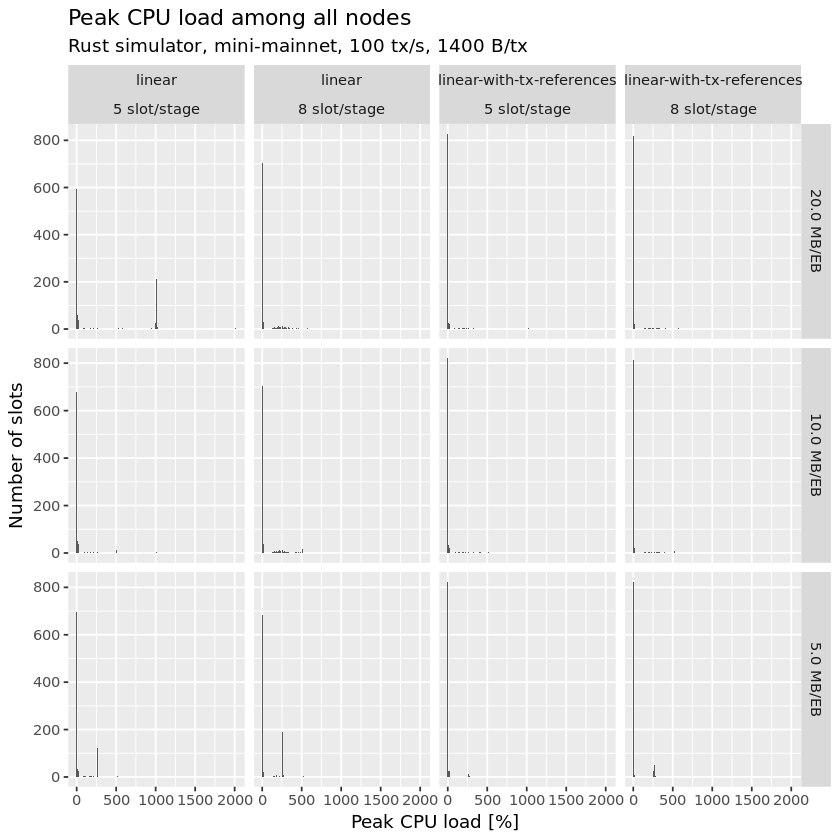

In [61]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/cpu-peak-histogram.png")
)

##### Time series

In [62]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=4, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scale=scales) +
#       scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

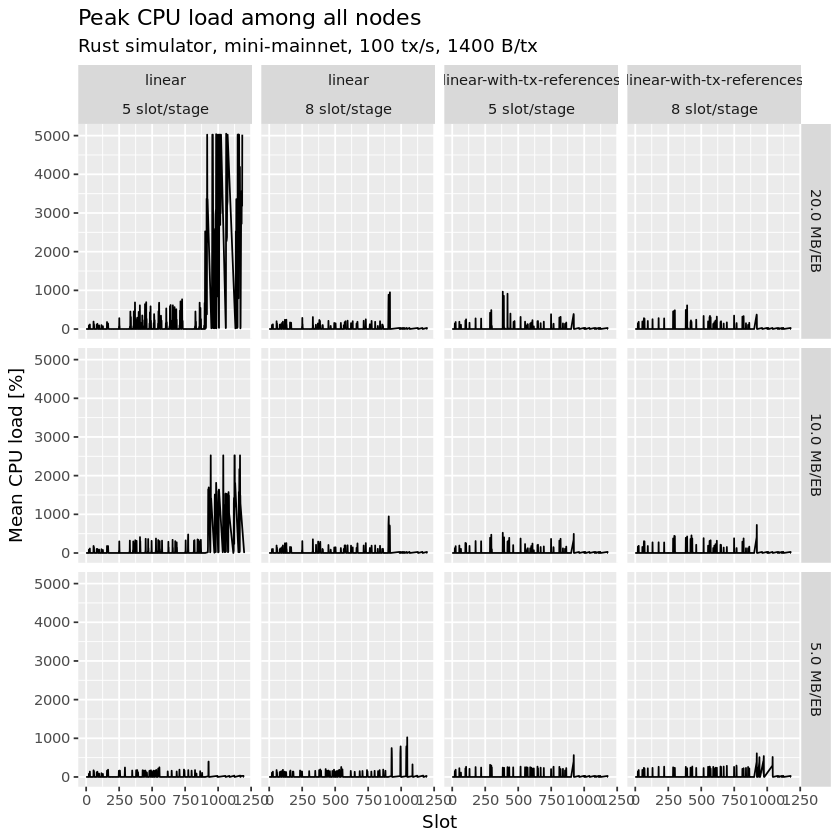

In [63]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [64]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=4, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

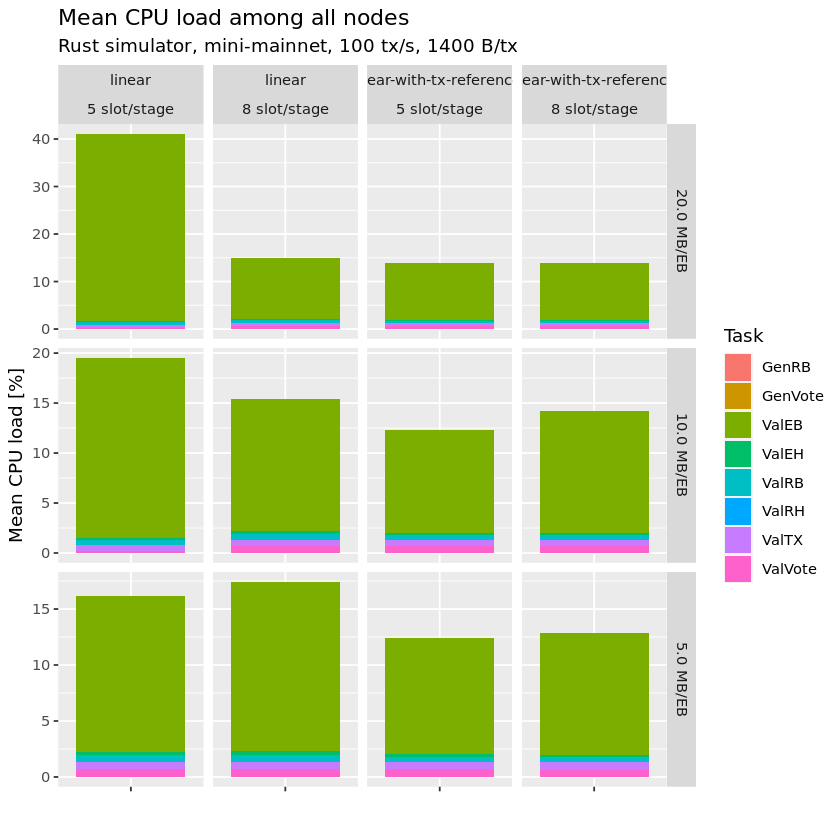

In [65]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/cpu-mean-histogram.png")
)

##### Time series

In [66]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=4, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Max EB size` ~ `Variant` + `Stage length`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

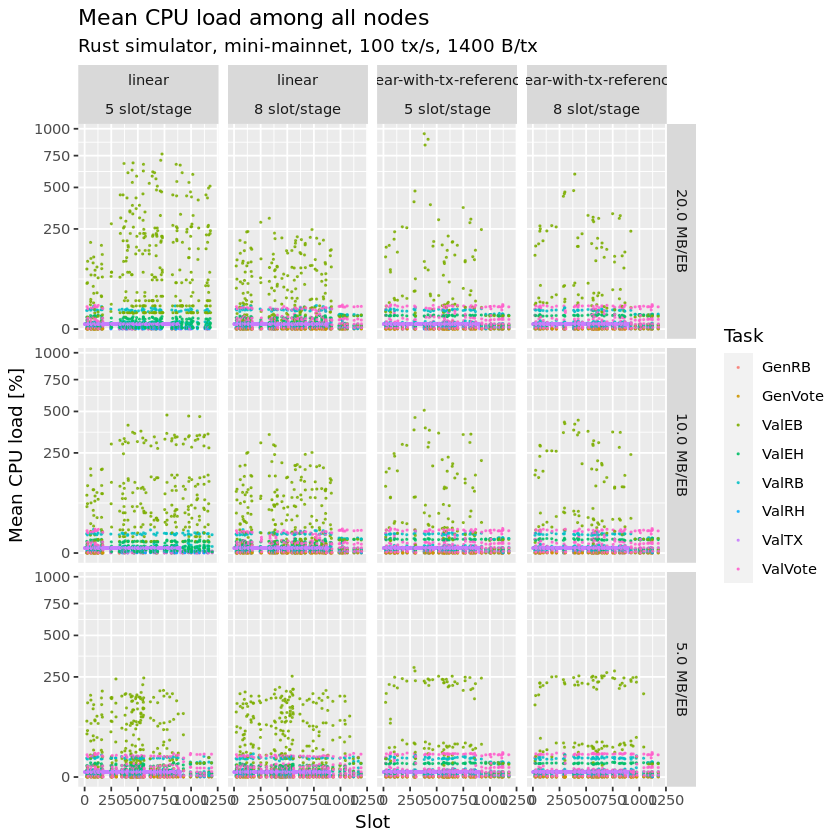

In [67]:
meanCpuTimeseries(
    cpus, 
    nodeCount * sampleSize, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cpu-mean-timeseries.png")
)

#### Release memory

In [68]:
rm(cpus, cpusNode)

In [69]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1020707,54.6,2538492,135.6,2538492,135.6
Vcells,798650357,6093.3,3162918826,24131.2,6177575831,47131.2


## Block contents

### Read data

In [3]:
sizes <- fread("sizes.csv", stringsAsFactors=TRUE)
sizes[, `Max EB size`:=factor(`Max EB size`, levels=c("20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB"))]
sizes %>% summary

 Simulator                        Variant          Stage length
 Rust:1382   linear                   :734   5 slot/stage:690  
             linear-with-tx-references:648   8 slot/stage:692  
                                                               
                                                               
                                                               
                                                               
                                                               
     Max EB size  Kind               Item      Generated [s]    
 20.0 MB/EB:452   EB:691   20-node-220 :  24   Min.   :  20.07  
 10.0 MB/EB:450   RB:691   26-node-95  :  24   1st Qu.: 326.07  
 5.0 MB/EB :480            54-node-525 :  24   Median : 575.08  
                           95-node-178 :  18   Mean   : 589.49  
                           1122-node-96:  14   3rd Qu.: 856.58  
                           650-node-579:  14   Max.   :1197.08  
                           (Other

### EB contents

#### Transactions

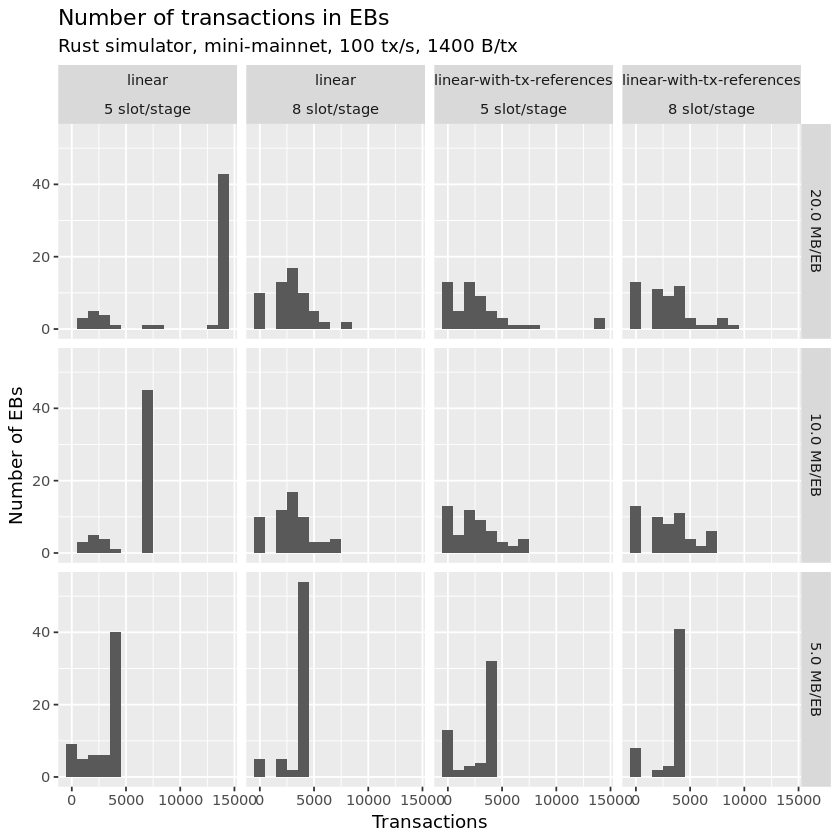

In [4]:
ggplot(sizes[`Kind` == "EB"], aes(x=`Transactions`)) +
    geom_histogram(binwidth=1000) +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`) +
    ylab("Number of EBs") +
    ggtitle("Number of transactions in EBs", label)

In [5]:
ggsave("plots/contents-ebs-txs.png", units="in", dpi=150, width=10, height=6)

#### Sizes

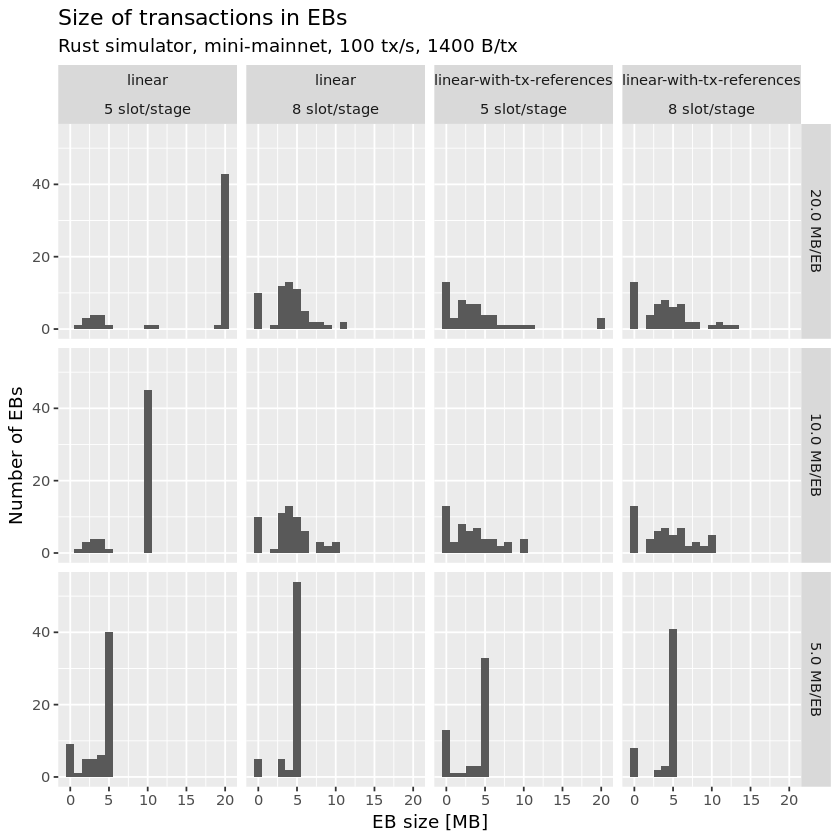

In [6]:
ggplot(sizes[`Kind` == "EB", .(`EB size [MB]`=`Transactions`*1400/1e6), .(`Variant`, `Stage length`, `Max EB size`)], aes(x=`EB size [MB]`)) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`) +
    ylab("Number of EBs") +
    ggtitle("Size of transactions in EBs", label)

In [7]:
ggsave("plots/contents-ebs-size.png", units="in", dpi=150, width=10, height=6)

### RB contents

#### Transactions

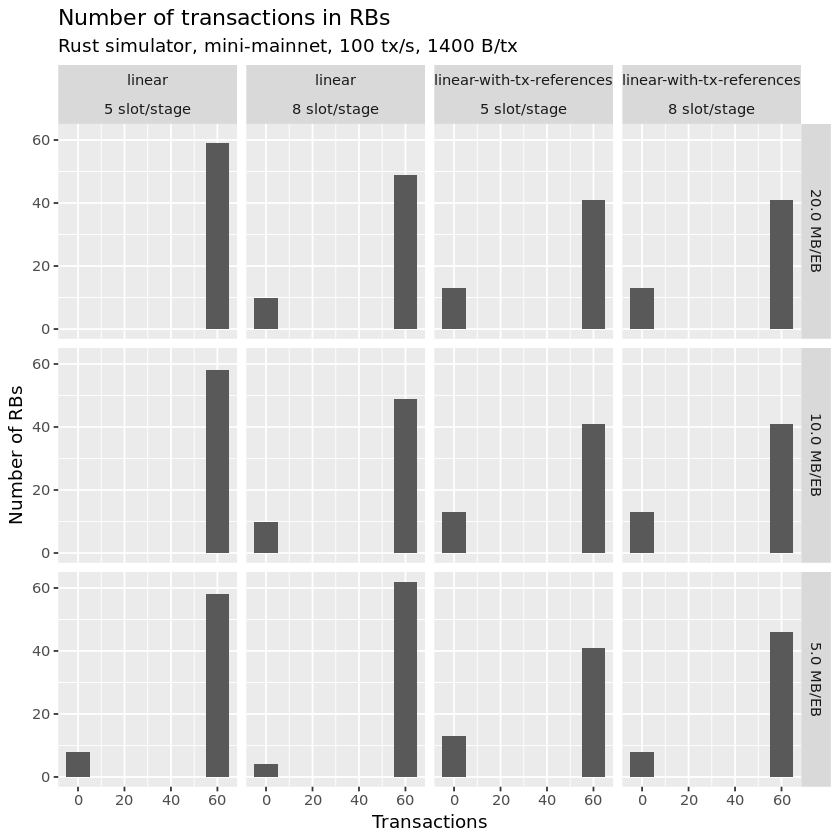

In [8]:
ggplot(sizes[`Kind` == "RB"], aes(x=`Transactions`)) +
    geom_histogram(binwidth=10) +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`) +
    ylab("Number of RBs") +
    ggtitle("Number of transactions in RBs", label)

In [9]:
ggsave("plots/contents-rbs-txs.png", units="in", dpi=150, width=10, height=6)

#### Sizes

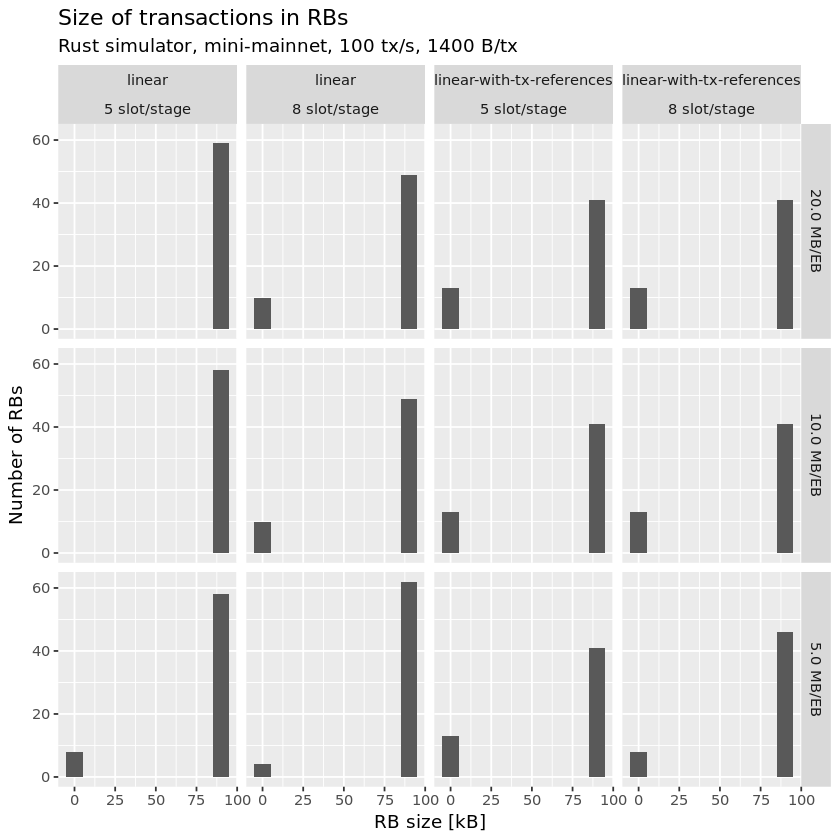

In [10]:
ggplot(sizes[`Kind` == "RB", .(`RB size [kB]`=`Transactions`*1400/1e3), .(`Variant`, `Stage length`, `Max EB size`)], aes(x=`RB size [kB]`)) +
    geom_histogram(binwidth=10) +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`) +
    ylab("Number of RBs") +
    ggtitle("Size of transactions in RBs", label)

In [11]:
ggsave("plots/contents-ebs-size.png", units="in", dpi=150, width=10, height=6)

### Disposition of blocks

#### Data processing

In [12]:
ebSizes <- sizes[`Kind` == "RB" & !is.na(`Endorses`), .(`Certified`=TRUE), .(`Variant`, `Stage length`, `Max EB size`, `Item`=`Endorses`)][
    sizes[`Kind` == "EB", .(`EB Transactions`=`Transactions`), .(`Variant`, `Stage length`, `Max EB size`, `Item`)], 
    on=c("Variant", "Stage length", "Max EB size", "Item")
][
    ,
    .(
        `EB txs later not certified`=ifelse(is.na(`Certified`), as.numeric(`EB Transactions`), 0),
        `EB txs later certified`=ifelse(is.na(`Certified`), 0, as.numeric(`EB Transactions`))
    ),
    .(`Variant`, `Stage length`, `Max EB size`, `Item`)
]

In [13]:
rbSizes <- ebSizes[
    ebSizes[, .(`EB txs certified now`=`EB txs later certified`), .(`Variant`, `Stage length`, `Max EB size`, `Endorses`=`Item`)][
        sizes[`Kind` == "RB", .(`Generated [s]`, `RB Transactions`=as.numeric(`Transactions`)), .(`Variant`, `Stage length`, `Max EB size`, `Item`, `Endorses`)],
        on=c("Variant", "Stage length", "Max EB size", "Endorses")
    ],
    on=c("Variant", "Stage length", "Max EB size", "Item")
][
    ,
    .(
        `Generated [s]`,
        `RB`=`RB Transactions`,
        `EB later not certified`=`EB txs later not certified`,
        `EB later certified`=`EB txs later certified`,
        `EB now certified`=ifelse(is.na(`EB txs certified now`), 0, `EB txs certified now`)
    ),
    , .(`Variant`, `Stage length`, `Max EB size`, `Item`)
]

In [14]:
blocks <- melt(
    rbSizes, 
    id.vars=c("Variant", "Stage length", "Max EB size", "Item", "Generated [s]"),
    measure.vars=c("RB", "EB later not certified", "EB later certified", "EB now certified"),
    variable.name="Block",
    value.name="Transactions"
)

#### Sanity checks

In [15]:
ebSizes[, .N] == sizes[`Kind` == "EB", .N]

[1] TRUE

In [16]:
ebSizes[, sum(`EB txs later not certified`) + sum(`EB txs later certified`)] == sizes[`Kind` == "EB", sum(`Transactions`)]

[1] TRUE

In [17]:
rbSizes[, .N] == sizes[`Kind` == "RB", .N]

[1] TRUE

In [18]:
rbSizes[, sum(`RB`)] == sizes[`Kind` == "RB", sum(`Transactions`)]

[1] TRUE

In [19]:
rbSizes[, sum(`EB later not certified`) + sum(`EB later certified`)] == sizes[`Kind` == "EB", sum(`Transactions`)]

[1] TRUE

In [20]:
# TODO: Compute precise equality that accounts for forks.
rbSizes[, sum(`EB later certified`)] <= rbSizes[, sum(`EB now certified`)]

[1] TRUE

#### Transactions

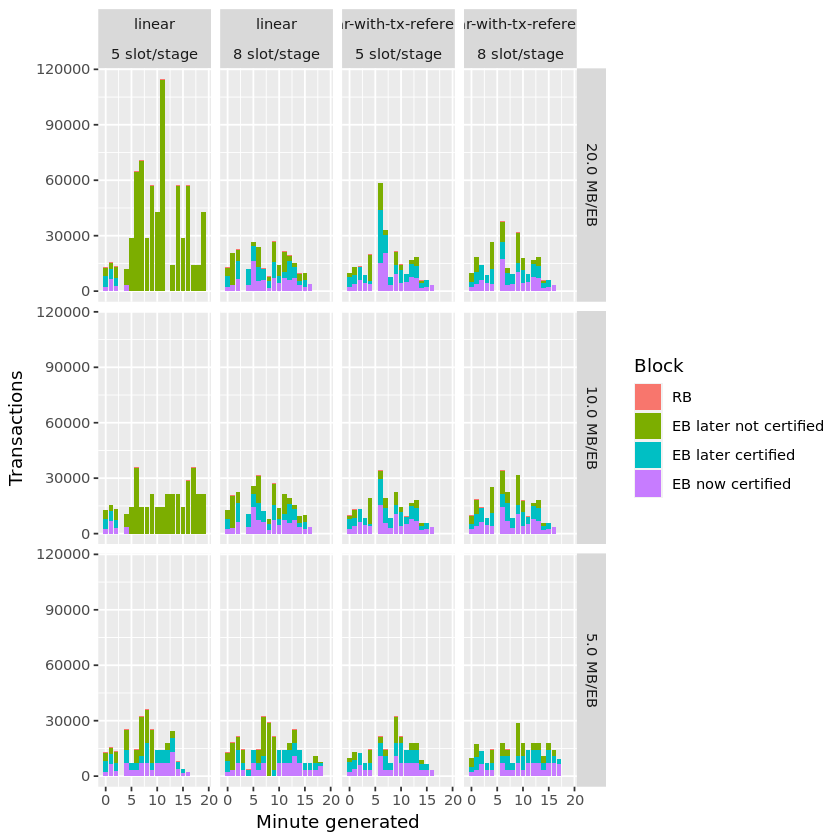

In [21]:
ggplot(
    blocks[, .(`Transactions`=sum(`Transactions`)), .(`Variant`, `Stage length`, `Max EB size`, `Block`, `Minute generated`=(floor(`Generated [s]`/60)))], 
    aes(x=`Minute generated`, y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`)

In [22]:
ggsave("plots/disposition-txs-timeseries.png", units="in", dpi=150, width=10, height=6)

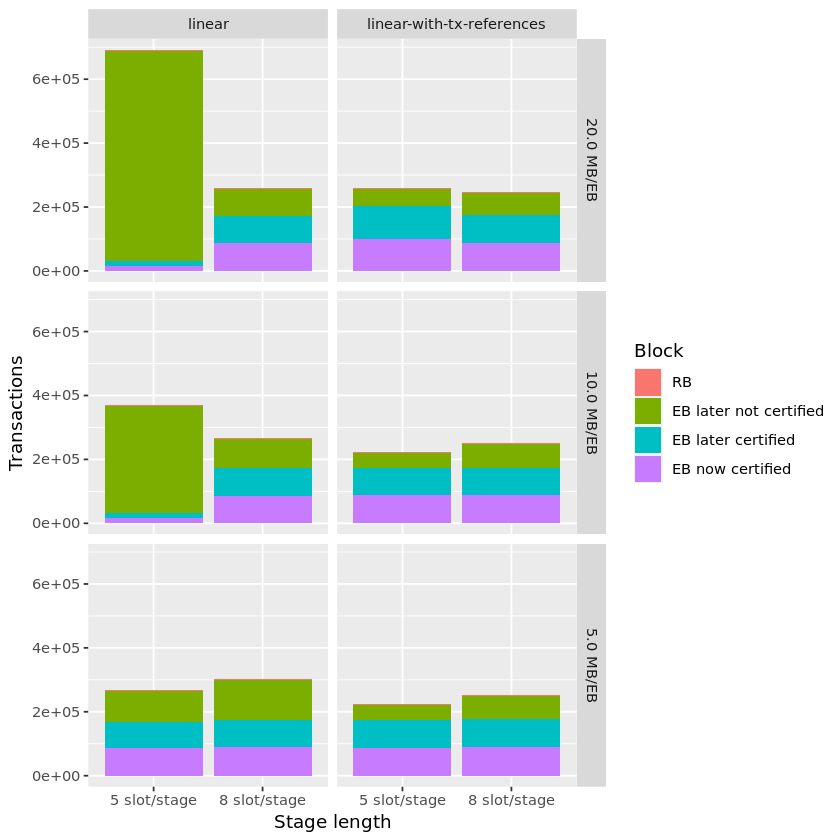

In [23]:
ggplot(
    blocks[, .(`Transactions`=sum(`Transactions`)), .(`Variant`, `Stage length`, `Max EB size`, `Block`)], 
    aes(x=`Stage length`, y=`Transactions`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Variant`)

In [24]:
ggsave("plots/disposition-txs-histogram.png", units="in", dpi=150, width=10, height=6)

#### Sizes

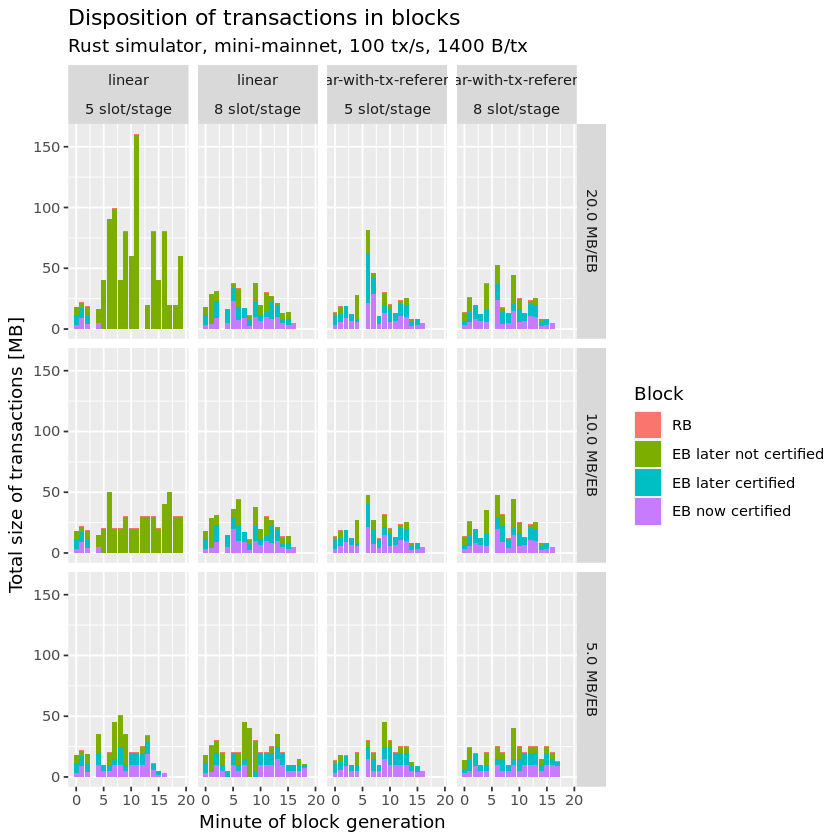

In [25]:
ggplot(
    blocks[, .(`Total size of transactions [MB]`=sum(`Transactions`)*1400/1e6), .(`Variant`, `Stage length`, `Max EB size`, `Block`, `Minute of block generation`=(floor(`Generated [s]`/60)))], 
    aes(x=`Minute of block generation`, y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Variant` + `Stage length`) +
    ggtitle("Disposition of transactions in blocks", label)

In [26]:
ggsave("plots/disposition-size-timeseries.png", units="in", dpi=150, width=10, height=6)

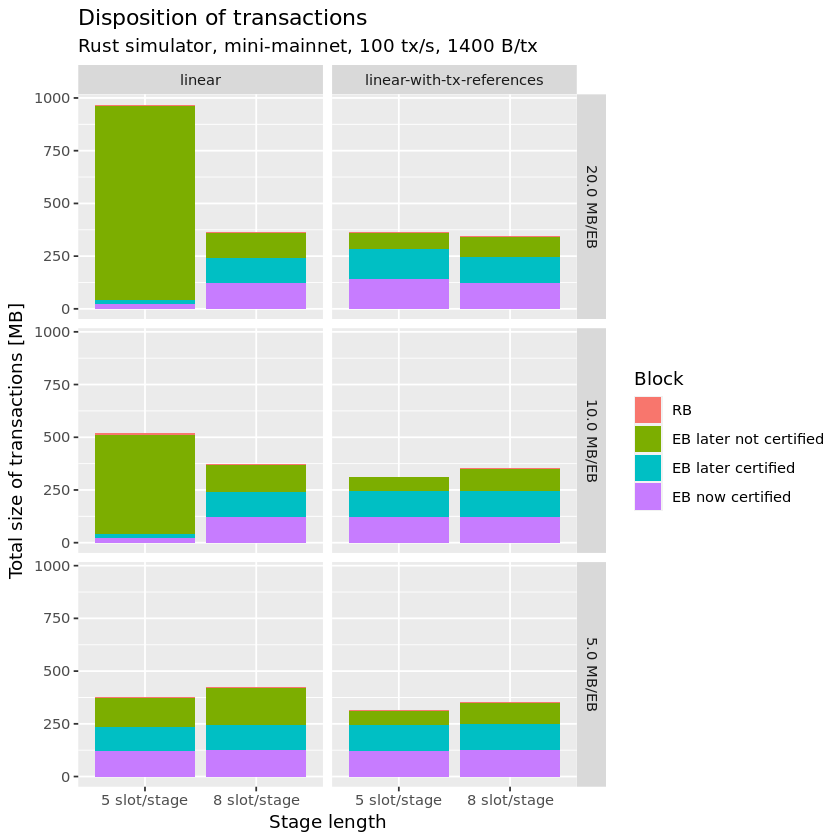

In [27]:
ggplot(
    blocks[, .(`Total size of transactions [MB]`=sum(`Transactions`)*1400/1e6), .(`Variant`, `Stage length`, `Max EB size`, `Block`)], 
    aes(x=`Stage length`, y=`Total size of transactions [MB]`, fill=`Block`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Variant`) +
    ggtitle("Disposition of transactions", label)

In [28]:
ggsave("plots/disposition-size-histogram.png", units="in", dpi=150, width=10, height=6)